####LIBRERÍAS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from IPython.display import display

#### CREACIÓN Y PREPROCESAMIENTO DE LA BASE DE DATOS

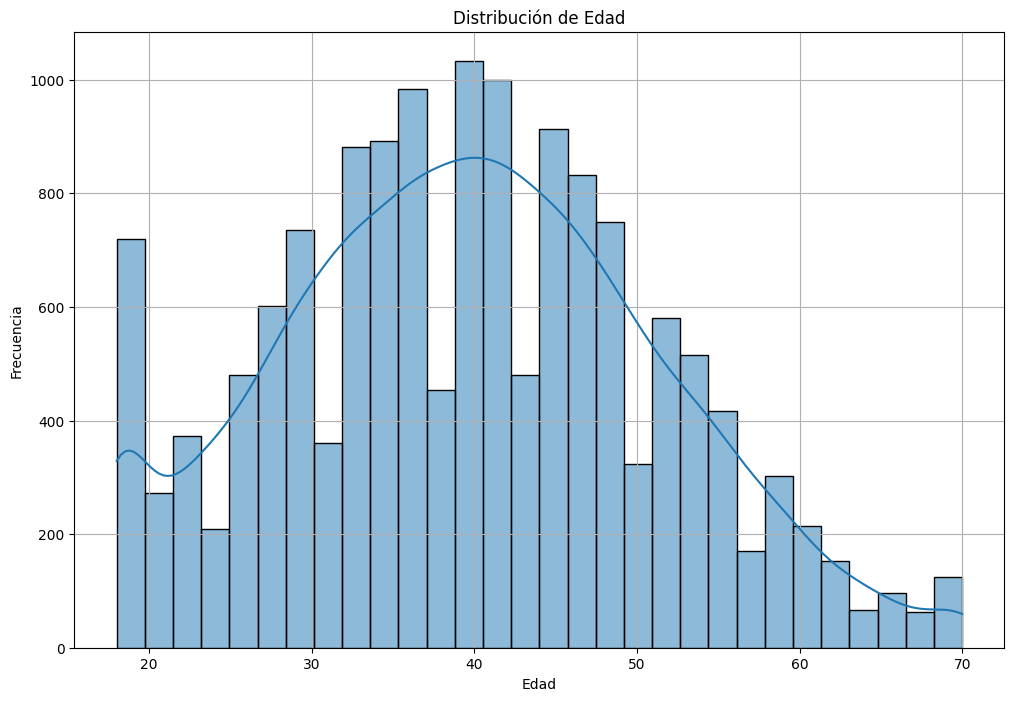

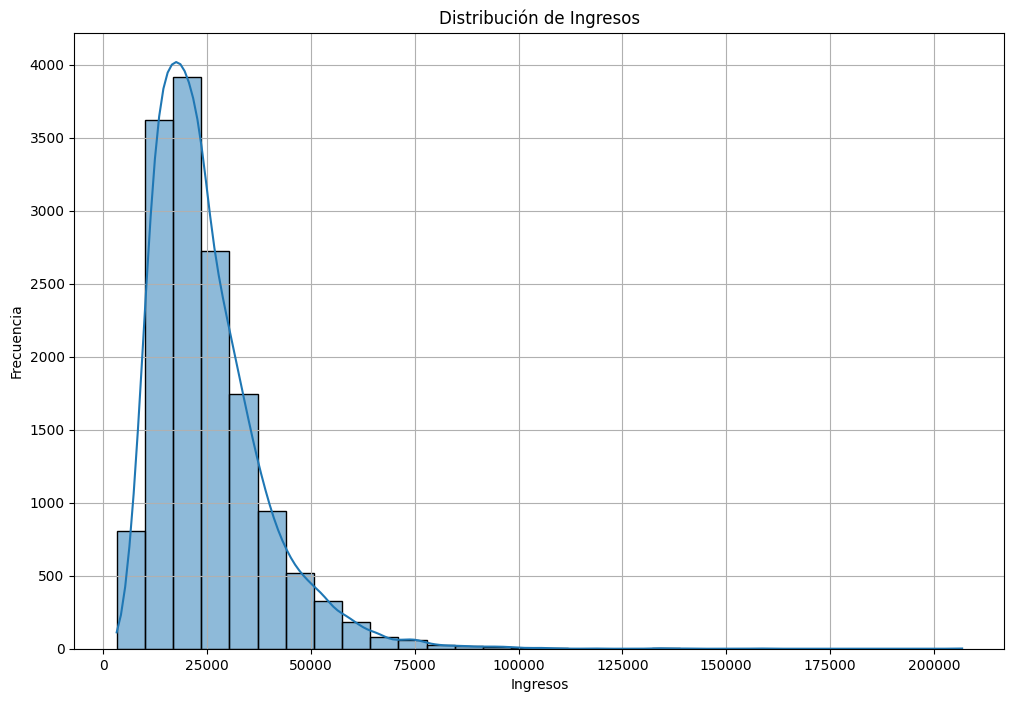

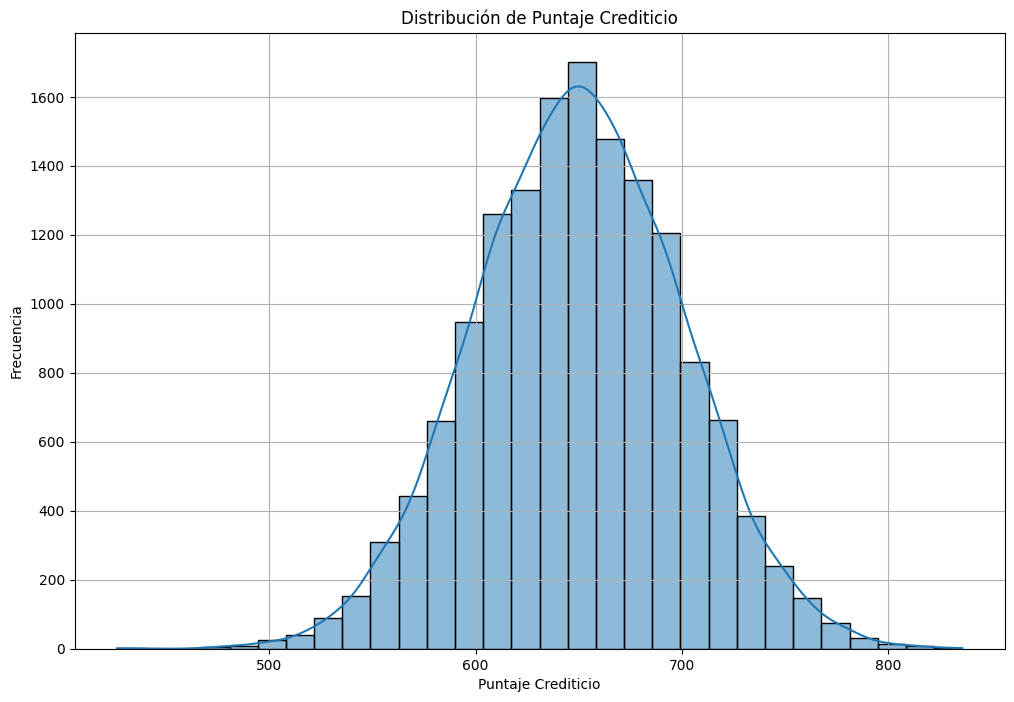

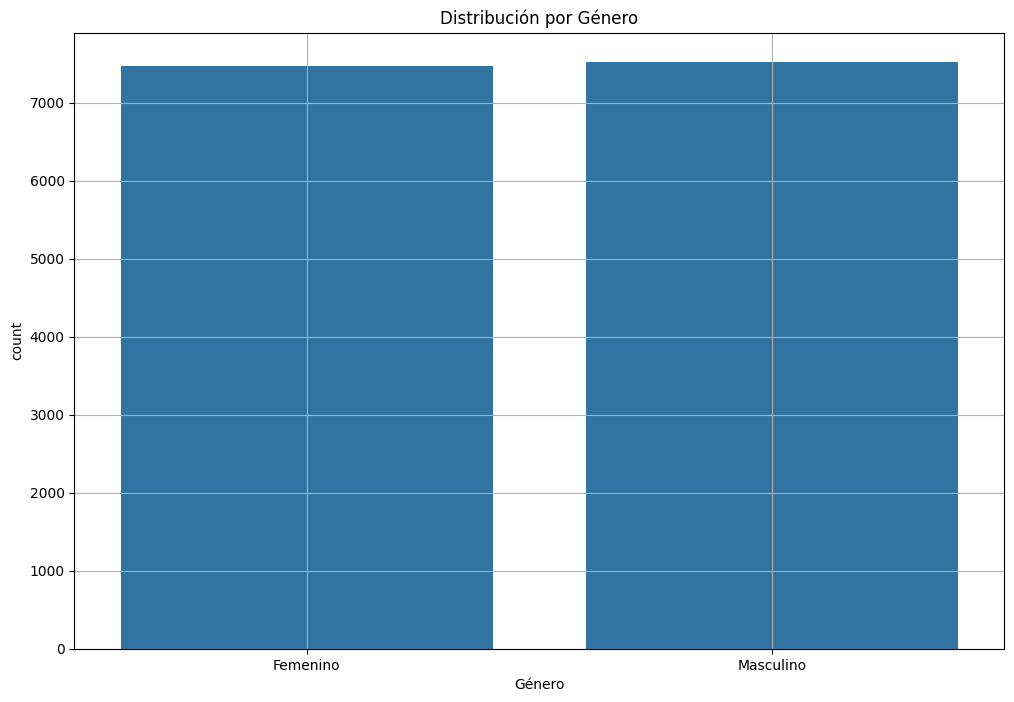

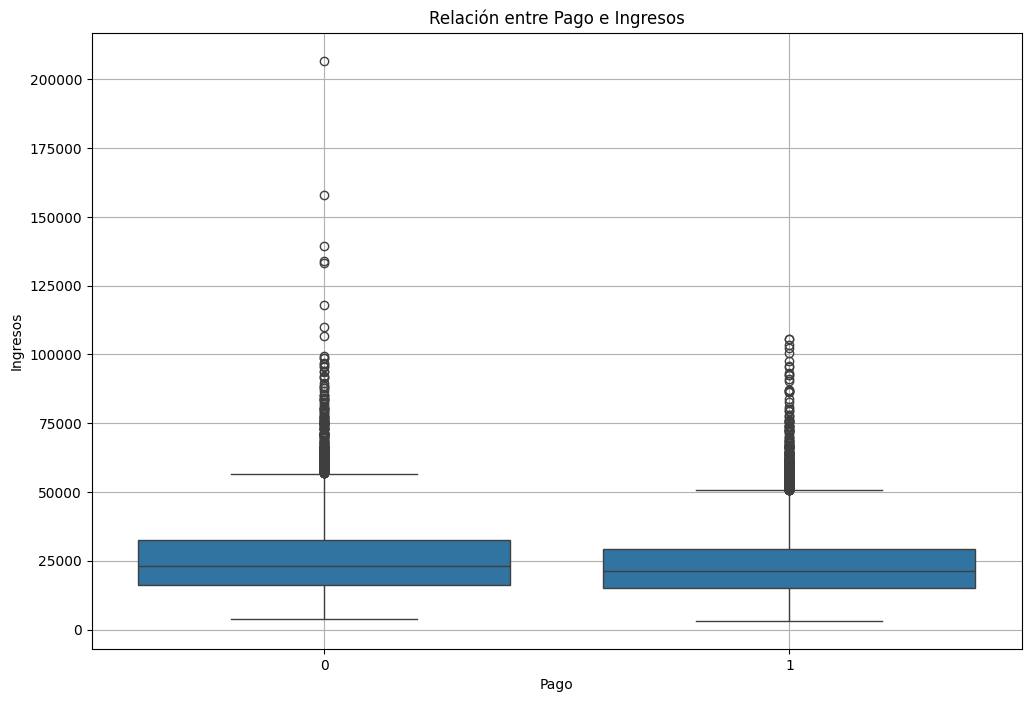

Correlación de todas las variables con la variable objetivo 'Pago':

Pago                                1.000000
Estabilidad_Emocional              -0.208674
Puntaje_Crediticio                 -0.127406
Deuda_Pendiente                     0.107457
Ingresos                           -0.093149
Edad                                0.017394
Tolerancia_Riesgo_Baja             -0.011606
Tolerancia_Riesgo_Media             0.006715
Estado_Civil_Viudo                 -0.006493
Cantidad_Préstamo                  -0.006428
Ubicación_Málaga                   -0.005875
Ubicación_Madrid                    0.005136
Ubicación_Valencia                  0.003884
Género_Masculino                    0.003247
Ubicación_Sevilla                   0.002562
Ubicación_Zaragoza                  0.002533
Estado_Civil_Soltero                0.001985
Planificación_Financiera_Regular   -0.001912
Estado_Civil_Divorciado            -0.001131
Planificación_Financiera_Mala      -0.000207
Name: Pago, dtype: float64


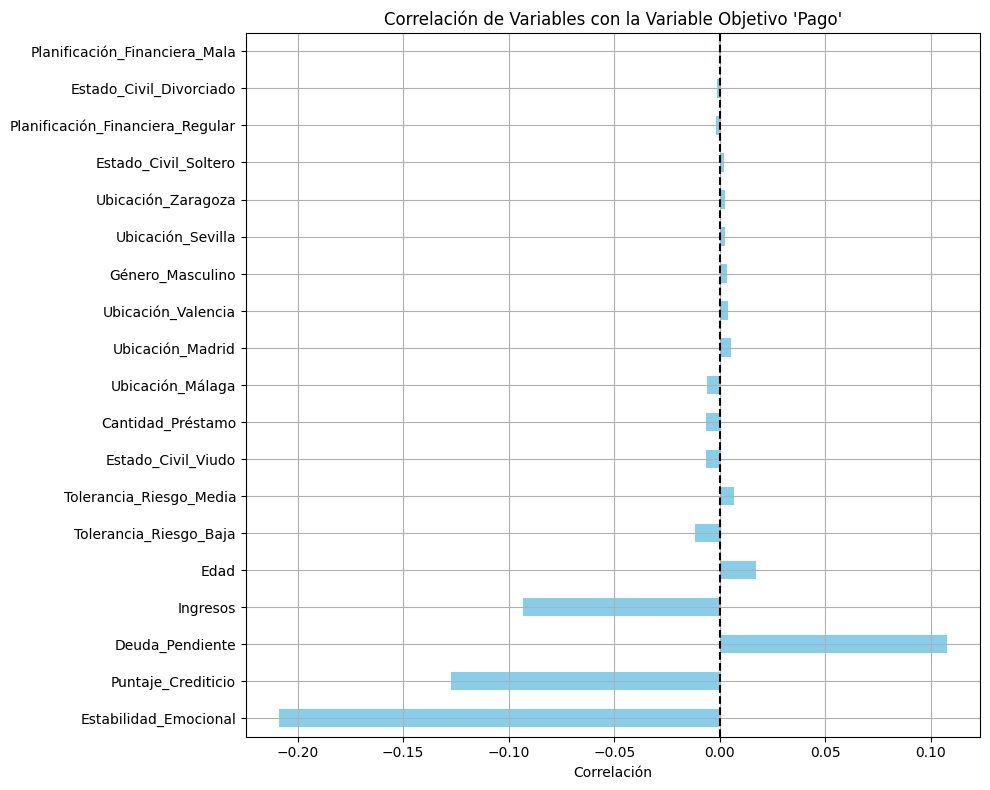

RandomForestClassifier(max_depth=10, random_state=42)

In [ ]:

# Generar la base sintética realista
num_samples = 15000
np.random.seed(42)

# Variables numéricas realistas
edad = np.random.normal(loc=40, scale=12, size=num_samples).clip(18, 70).astype(int)
ingresos = np.random.lognormal(mean=10, sigma=0.5, size=num_samples).astype(int)
puntaje_crediticio = np.random.normal(loc=650, scale=50, size=num_samples).clip(300, 850).astype(int)
deuda_pendiente = np.random.normal(loc=15000, scale=8000, size=num_samples).clip(0).round(2)
cantidad_prestamo = np.random.normal(loc=30000, scale=12000, size=num_samples).clip(500, 100000).round(2)
estabilidad_emocional = np.random.uniform(0, 1, size=num_samples).round(2)

# Variables categóricas realistas
genero = np.random.choice(['Masculino', 'Femenino'], size=num_samples)
estado_civil = np.random.choice(['Soltero', 'Casado', 'Divorciado', 'Viudo'], size=num_samples, p=[0.45, 0.35, 0.15, 0.05])
ubicacion = np.random.choice(['Madrid', 'Barcelona', 'Valencia', 'Sevilla', 'Zaragoza', 'Málaga'], size=num_samples)
tolerancia_riesgo = np.random.choice(['Baja', 'Media', 'Alta'], size=num_samples, p=[0.3, 0.5, 0.2])
planificacion_financiera = np.random.choice(['Buena', 'Regular', 'Mala'], size=num_samples, p=[0.4, 0.4, 0.2])

# Pago: función condicional simple (más realista)
pago_prob = (ingresos / ingresos.max()) + (puntaje_crediticio - 300) / 550 - (deuda_pendiente / 100000) + (estabilidad_emocional * 0.5)
pago_prob = (pago_prob - pago_prob.min()) / (pago_prob.max() - pago_prob.min())
pago = np.random.binomial(1, pago_prob.clip(0, 1))

pago=1-pago

# Construir DataFrame sintético
synthetic_data = pd.DataFrame({
    "Edad": edad,
    "Género": genero,
    "Estado_Civil": estado_civil,
    "Ubicación": ubicacion,
    "Ingresos": ingresos,
    "Puntaje_Crediticio": puntaje_crediticio,
    "Deuda_Pendiente": deuda_pendiente,
    "Cantidad_Préstamo": cantidad_prestamo,
    "Tolerancia_Riesgo": tolerancia_riesgo,
    "Estabilidad_Emocional": estabilidad_emocional,
    "Planificación_Financiera": planificacion_financiera,
    "Pago": pago
})


# Exportar a CSV para uso externo
synthetic_data.to_csv("base_sintetica_credito.csv", index=False)

# Visualización exploratoria
plt.figure(figsize=(12, 8))
sns.histplot(synthetic_data['Edad'], kde=True, bins=30)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(synthetic_data['Ingresos'], kde=True, bins=30)
plt.title('Distribución de Ingresos')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.histplot(synthetic_data['Puntaje_Crediticio'], kde=True, bins=30)
plt.title('Distribución de Puntaje Crediticio')
plt.xlabel('Puntaje Crediticio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='Género', data=synthetic_data)
plt.title('Distribución por Género')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Pago', y='Ingresos', data=synthetic_data)
plt.title('Relación entre Pago e Ingresos')
plt.grid(True)
plt.show()


#  One-Hot Encoding de categóricas
df_encoded = pd.get_dummies(synthetic_data.drop(columns=["Pago"]), drop_first=True)

#  Añadir la variable objetivo
df_encoded["Pago"] = synthetic_data["Pago"]

# Calcular correlaciones con "Pago"
correlations = df_encoded.corr(numeric_only=True)["Pago"].sort_values(key=abs, ascending=False)

# Mostrar como tabla
print("Correlación de todas las variables con la variable objetivo 'Pago':\n")
print(correlations)

# Visualizar en gráfico de barras

plt.figure(figsize=(10, 8))
correlations.drop("Pago").plot(kind="barh", color="skyblue")
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Correlación de Variables con la Variable Objetivo 'Pago'")
plt.xlabel("Correlación")
plt.tight_layout()
plt.grid(True)
plt.show()




# Separar X e y
X = synthetic_data.drop(columns=["Pago"])
y = synthetic_data["Pago"]

# Detectar tipos
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocesamiento
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar transformaciones
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100,max_depth=10, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)




####REGRESIÓN LOGÍSTICA

=== Clasificación - Regresión Logística ===
              precision    recall  f1-score   support

           0       0.55      0.61      0.58      1388
           1       0.63      0.57      0.60      1612

    accuracy                           0.59      3000
   macro avg       0.59      0.59      0.59      3000
weighted avg       0.59      0.59      0.59      3000



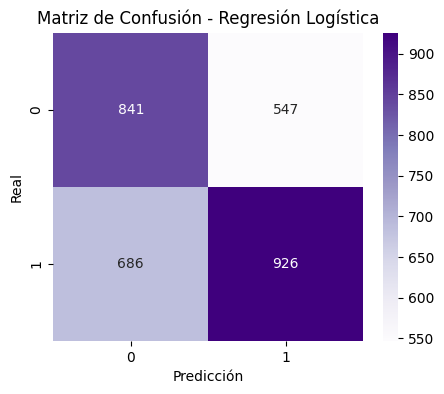

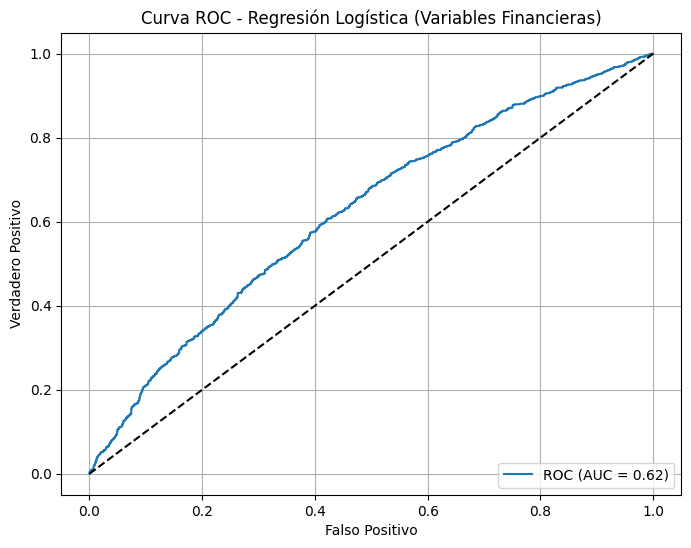

In [ ]:

# Selección de variables financieras
X_fin = synthetic_data[["Ingresos", "Puntaje_Crediticio", "Deuda_Pendiente", "Cantidad_Préstamo"]]
y_fin = synthetic_data["Pago"]

# División del dataset
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(
    X_fin, y_fin, test_size=0.2, stratify=y_fin, random_state=42
)

# Escalado
scaler_fin = StandardScaler()
X_train_fin_scaled = scaler_fin.fit_transform(X_train_fin)
X_test_fin_scaled = scaler_fin.transform(X_test_fin)

# Balanceo de clases
weights_fin = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(y_train_fin),
                                                y=y_train_fin)

class_weights_fin = {0: weights_fin[0], 1: weights_fin[1]}

# Modelo de regresión logística
logreg = LogisticRegression(class_weight=class_weights_fin, solver='liblinear')
logreg.fit(X_train_fin_scaled, y_train_fin)

# Predicciones
y_pred_fin = logreg.predict(X_test_fin_scaled)
y_pred_prob_fin = logreg.predict_proba(X_test_fin_scaled)[:, 1]

# Evaluación
print("=== Clasificación - Regresión Logística ===")
print(classification_report(y_test_fin, y_pred_fin))

# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_fin, y_pred_fin), annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

# Curva ROC
fpr_fin, tpr_fin, _ = roc_curve(y_test_fin, y_pred_prob_fin)
auc_fin = roc_auc_score(y_test_fin, y_pred_prob_fin)

plt.figure(figsize=(8, 6))
plt.plot(fpr_fin, tpr_fin, label=f'ROC (AUC = {auc_fin:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadero Positivo')
plt.title('Curva ROC - Regresión Logística (Variables Financieras)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


####RANDOM FOREST

=== Clasificación - Random Forest ===
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      1421
           1       0.64      0.62      0.63      1579

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000



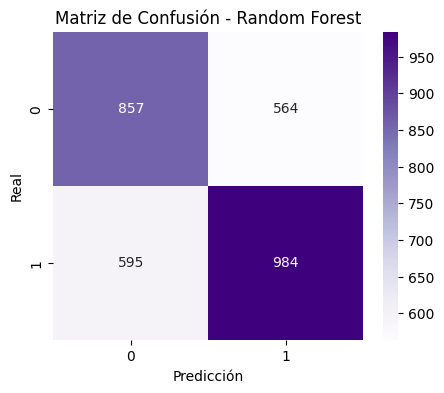


Ejemplos de predicciones (fallos incluidos):
      Edad     Género Estado_Civil  Ubicación  Ingresos  Puntaje_Crediticio  \
1738    18   Femenino       Casado    Sevilla     39303                 661   
319     47   Femenino      Soltero     Madrid     16279                 668   
2875    40  Masculino   Divorciado    Sevilla     16949                 673   
172     27  Masculino      Soltero   Valencia     17909                 685   
1046    37   Femenino       Casado    Sevilla     18905                 744   
2379    37   Femenino       Casado  Barcelona     22070                 671   
1984    44  Masculino       Casado   Zaragoza      9468                 612   
1367    40   Femenino       Casado    Sevilla     10293                 530   
568     41  Masculino       Casado     Málaga     27468                 669   
722     53   Femenino      Soltero   Valencia     20676                 648   

      Deuda_Pendiente  Cantidad_Préstamo Tolerancia_Riesgo  \
1738         25184.86 

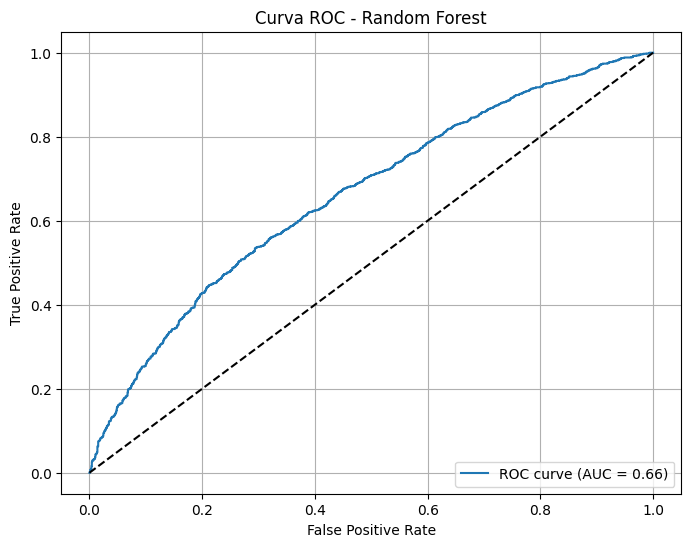

In [ ]:
# Evaluación
y_pred = rf_model.predict(X_test_processed)
y_pred_prob = rf_model.predict_proba(X_test_processed)[:, 1]

print("=== Clasificación - Random Forest ===")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Mostrar ejemplos de predicción
X_test_original = X_test.reset_index(drop=True)
resultado_df = X_test_original.copy()
resultado_df["Prob_Pago"] = y_pred_prob
resultado_df["Prediccion"] = y_pred
resultado_df["Real"] = y_test.reset_index(drop=True)

print("\nEjemplos de predicciones (fallos incluidos):")
print(resultado_df.sample(10))
print("\nEjemplos donde falló la predicción:")
print(resultado_df[resultado_df["Prediccion"] != resultado_df["Real"]].sample(10))

# ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

####RED NEURONAL PROFUNDA

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4801 - loss: 0.7466 - val_accuracy: 0.4792 - val_loss: 0.7180 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4917 - loss: 0.7403 - val_accuracy: 0.5142 - val_loss: 0.7134 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5065 - loss: 0.7225 - val_accuracy: 0.5337 - val_loss: 0.7076 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5157 - loss: 0.7197 - val_accuracy: 0.5587 - val_loss: 0.7035 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5310 - loss: 0.7165 - val_accuracy: 0.5658 - val_loss: 0.7004 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5372 - loss: 0.7086 - val_accuracy: 0.5692 - val_loss: 0.6977 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.543

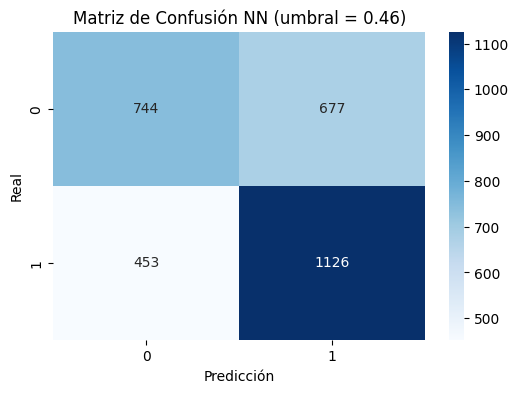

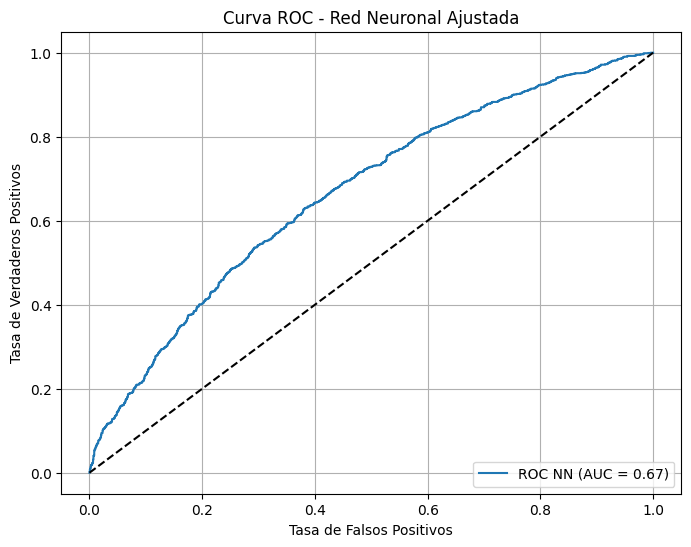

In [ ]:

# Pesos de clase balanceados
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Arquitectura de la Red Neuronal

model = Sequential([

    Dense(256, kernel_regularizer=l2(0.0005), input_shape=(X_train_processed.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.37),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.35),

    Dense(16),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.23),

    Dense(8),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

# Compilación
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3)

# Entrenamiento
history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_reduce],
    class_weight=class_weights,
    verbose=1
)

# Evaluación
y_pred_prob_nn = model.predict(X_test_processed).ravel()
optimal_threshold = 0.46
y_pred_nn_opt = (y_pred_prob_nn > optimal_threshold).astype(int)

print("=== Clasificación - Red Neuronal con umbral = 0.46 ===")
print(classification_report(y_test, y_pred_nn_opt))

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_nn_opt), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión NN (umbral = 0.46)")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_nn)
auc_nn = roc_auc_score(y_test, y_pred_prob_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC NN (AUC = {auc_nn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Red Neuronal Ajustada')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


####OPTIMIZACIÓN DEL UMBRAL DE DECISIÓN

 Mejores umbrales ordenados por F1 Score:


,Umbral,F1 Score,Recall Clase 1,Accuracy
6,0.40,0.696709,0.871438,0.600667
5,0.35,0.694253,0.956301,0.556667
4,0.30,0.693039,0.993034,0.537000
3,0.25,0.690591,0.999367,0.528667
0,0.10,0.689670,1.000000,0.526333


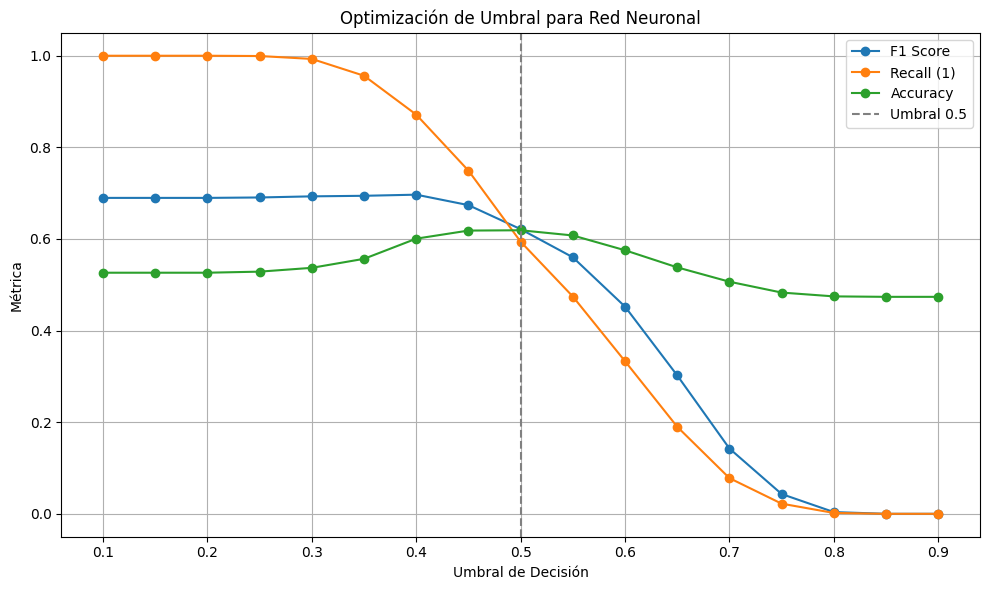

 Umbrales con mejor trade-off accuracy/recall:


,Umbral,F1 Score,Recall Clase 1,Accuracy
0,0.46,0.665878,0.713110,0.623333
2,0.48,0.637876,0.631412,0.622667
1,0.47,0.650432,0.668144,0.622000
3,0.49,0.629798,0.613046,0.620667
4,0.50,0.621398,0.594047,0.619000


In [ ]:

# Evaluar rendimiento en múltiples umbrales
thresholds = np.arange(0.1, 0.91, 0.05)
metrics = []

for t in thresholds:
    y_pred_temp = (y_pred_prob_nn > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    recall = recall_score(y_test, y_pred_temp)
    acc = accuracy_score(y_test, y_pred_temp)
    metrics.append((t, f1, recall, acc))

# Convertir a DataFrame
threshold_df = pd.DataFrame(metrics, columns=["Umbral", "F1 Score", "Recall Clase 1", "Accuracy"])

# Mostrar los mejores
best = threshold_df.sort_values("F1 Score", ascending=False).head(5)
print(" Mejores umbrales ordenados por F1 Score:")
display(best)

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(threshold_df["Umbral"], threshold_df["F1 Score"], label="F1 Score", marker='o')
plt.plot(threshold_df["Umbral"], threshold_df["Recall Clase 1"], label="Recall (1)", marker='o')
plt.plot(threshold_df["Umbral"], threshold_df["Accuracy"], label="Accuracy", marker='o')
plt.axvline(x=0.5, color='gray', linestyle='--', label='Umbral 0.5')
plt.xlabel("Umbral de Decisión")
plt.ylabel("Métrica")
plt.title("Optimización de Umbral para Red Neuronal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ajuste fino en el rango 0.46 a 0.51
fine_thresholds = np.arange(0.46, 0.51, 0.01)
fine_metrics = []

for t in fine_thresholds:
    y_pred_fine = (y_pred_prob_nn > t).astype(int)
    f1 = f1_score(y_test, y_pred_fine)
    recall = recall_score(y_test, y_pred_fine)
    acc = accuracy_score(y_test, y_pred_fine)
    fine_metrics.append((t, f1, recall, acc))

# Convertir a DataFrame
fine_df = pd.DataFrame(fine_metrics, columns=["Umbral", "F1 Score", "Recall Clase 1", "Accuracy"])
fine_df = fine_df.sort_values(by="Accuracy", ascending=False)

print(" Umbrales con mejor trade-off accuracy/recall:")
display(fine_df)

##METODOS DE VALIDACIÓN

####VALIDACIÓN CRUZADA ESTRATIFICADA



 Fold 1
F1: 0.670, Recall: 0.709, Accuracy: 0.623

 Fold 2
F1: 0.669, Recall: 0.708, Accuracy: 0.621

 Fold 3
F1: 0.670, Recall: 0.714, Accuracy: 0.620

 Fold 4
F1: 0.661, Recall: 0.701, Accuracy: 0.612

 Fold 5
F1: 0.658, Recall: 0.693, Accuracy: 0.610

 Validación cruzada estratificada (5 folds)
F1 promedio: 0.665 ± 0.005
Recall promedio: 0.705 ± 0.007
Accuracy promedio: 0.617 ± 0.005


,Fold,F1 Score,Recall,Accuracy
0,1,0.670314,0.709105,0.623333
1,2,0.668609,0.708333,0.620833
2,3,0.669562,0.713735,0.619583
3,4,0.661091,0.701389,0.611667
4,5,0.657635,0.692901,0.610417


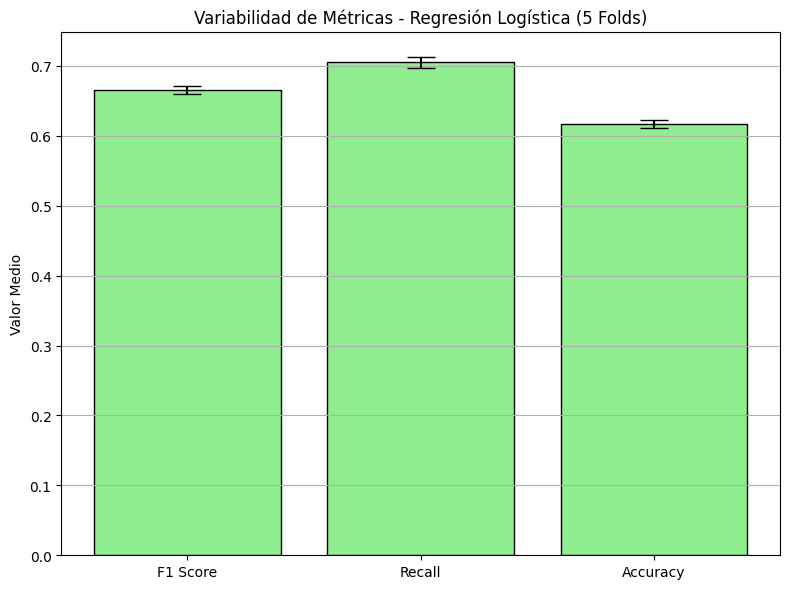


 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5186 - loss: 0.8105 - val_accuracy: 0.5063 - val_loss: 0.7168 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5157 - loss: 0.7579 - val_accuracy: 0.5229 - val_loss: 0.7145 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5189 - loss: 0.7412 - val_accuracy: 0.5371 - val_loss: 0.7104 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5244 - loss: 0.7299 - val_accuracy: 0.5425 - val_loss: 0.7077 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5290 - loss: 0.7265 - val_accuracy: 0.5446 - val_loss: 0.7067 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5216 - loss: 0.7209 - val_accuracy: 0.5354 - val_loss: 0.7067 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4867 - loss: 0.7721 - val_accuracy: 0.5612 - val_loss: 0.7058 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5105 - loss: 0.7394 - val_accuracy: 0.5921 - val_loss: 0.6987 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5190 - loss: 0.7298 - val_accuracy: 0.5979 - val_loss: 0.6955 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5416 - loss: 0.7165 - val_accuracy: 0.6012 - val_loss: 0.6926 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5482 - loss: 0.7106 - val_accuracy: 0.6062 - val_loss: 0.6908 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5606 - loss: 0.7059 - val_accuracy: 0.6087 - val_loss: 0.6884 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.556

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4945 - loss: 0.7437 - val_accuracy: 0.5158 - val_loss: 0.7126 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5144 - loss: 0.7312 - val_accuracy: 0.5671 - val_loss: 0.7033 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5322 - loss: 0.7178 - val_accuracy: 0.5817 - val_loss: 0.6972 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5480 - loss: 0.7105 - val_accuracy: 0.5875 - val_loss: 0.6937 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5456 - loss: 0.7113 - val_accuracy: 0.5900 - val_loss: 0.6911 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5467 - loss: 0.7075 - val_accuracy: 0.5967 - val_loss: 0.6887 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.548

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4947 - loss: 0.7445 - val_accuracy: 0.5008 - val_loss: 0.7148 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5126 - loss: 0.7316 - val_accuracy: 0.5542 - val_loss: 0.7100 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5118 - loss: 0.7263 - val_accuracy: 0.5796 - val_loss: 0.7061 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5325 - loss: 0.7147 - val_accuracy: 0.5867 - val_loss: 0.7027 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5397 - loss: 0.7161 - val_accuracy: 0.5833 - val_loss: 0.7010 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5413 - loss: 0.7083 - val_accuracy: 0.5950 - val_loss: 0.6976 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.552

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4917 - loss: 0.7702 - val_accuracy: 0.5708 - val_loss: 0.7093 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5094 - loss: 0.7451 - val_accuracy: 0.5883 - val_loss: 0.7043 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5335 - loss: 0.7257 - val_accuracy: 0.5975 - val_loss: 0.7006 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5380 - loss: 0.7230 - val_accuracy: 0.5987 - val_loss: 0.6981 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5377 - loss: 0.7206 - val_accuracy: 0.5987 - val_loss: 0.6973 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5551 - loss: 0.7115 - val_accuracy: 0.6079 - val_loss: 0.6953 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.548

,Fold,F1 Score,Recall,Accuracy
0,1,0.666149,0.662037,0.641667
1,2,0.632129,0.607253,0.618333
2,3,0.640191,0.621914,0.622500
3,4,0.621821,0.584877,0.615833
4,5,0.640815,0.631173,0.617917


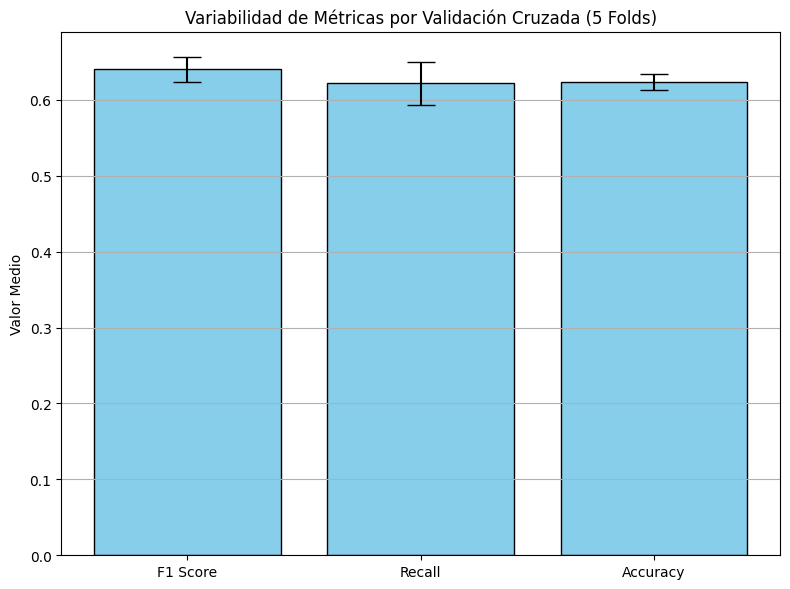

In [ ]:

# Inicialización
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
recalls = []
accuracies = []

# Validación cruzada
for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_processed, y_train)):
    print(f"\n Fold {fold + 1}")
    X_fold_train, X_fold_test = X_train_processed[train_idx], X_train_processed[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_fold_train, y_fold_train)
    y_pred = clf.predict(X_fold_test)

    f1 = f1_score(y_fold_test, y_pred)
    recall = recall_score(y_fold_test, y_pred)
    acc = accuracy_score(y_fold_test, y_pred)

    f1_scores.append(f1)
    recalls.append(recall)
    accuracies.append(acc)

    print(f"F1: {f1:.3f}, Recall: {recall:.3f}, Accuracy: {acc:.3f}")

# Resumen final
print("\n Validación cruzada estratificada (5 folds)")
print(f"F1 promedio: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"Recall promedio: {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"Accuracy promedio: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")

# Tabla de métricas por fold
results_df = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'F1 Score': f1_scores,
    'Recall': recalls,
    'Accuracy': accuracies
})
display(results_df)

# Gráfico de barras con desviación estándar
metric_means = results_df.drop(columns='Fold').mean()
metric_stds = results_df.drop(columns='Fold').std()

metrics_plot_df = pd.DataFrame({
    'Métrica': metric_means.index,
    'Media': metric_means.values,
    'Desviación Estándar': metric_stds.values
})

plt.figure(figsize=(8, 6))
plt.bar(metrics_plot_df['Métrica'], metrics_plot_df['Media'],
        yerr=metrics_plot_df['Desviación Estándar'], capsize=10,
        color='lightgreen', edgecolor='black')
plt.title('Variabilidad de Métricas - Regresión Logística (5 Folds)')
plt.ylabel('Valor Medio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
recalls = []
accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_processed, y_train)):
    print(f"\n Fold {fold + 1}")

    X_fold_train, X_fold_test = X_train_processed[train_idx], X_train_processed[test_idx]
    y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Red neuronal
    model = Sequential([

        Dense(256, kernel_regularizer=l2(0.0005), input_shape=(X_train_processed.shape[1],)),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.5),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.4),

        Dense(64),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.37),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.35),

        Dense(16),
        BatchNormalization(),
        LeakyReLU(alpha=0.01),
        Dropout(0.23),

        Dense(8),
        LeakyReLU(alpha=0.01),

        Dense(1, activation='sigmoid')
])

# Compilación
    model.compile(
        optimizer=Adam(learning_rate=0.0002),
        loss='binary_crossentropy',
        metrics=['accuracy']
)


# Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3)

# Entrenamiento
    history = model.fit(
        X_train_processed, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=64,
        callbacks=[early_stop, lr_reduce],
        class_weight=class_weights,
        verbose=1
)


    y_pred_prob = model.predict(X_fold_test).ravel()
    y_pred = (y_pred_prob > 0.48).astype(int)

    f1 = f1_score(y_fold_test, y_pred)
    recall = recall_score(y_fold_test, y_pred)
    acc = accuracy_score(y_fold_test, y_pred)

    f1_scores.append(f1)
    recalls.append(recall)
    accuracies.append(acc)

    print(f"F1: {f1:.3f}, Recall: {recall:.3f}, Accuracy: {acc:.3f}")

# Resumen final
print("\n Validación cruzada estratificada (5 folds)")
print(f"F1 promedio: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"Recall promedio: {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
print(f"Accuracy promedio: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")



# Creación del DataFrame con métricas por fold
results_df = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'F1 Score': f1_scores,
    'Recall': recalls,
    'Accuracy': accuracies
})

# Tabla de métricas por fold
display(results_df)

# Cálculo de medias y desviaciones estándar (sin incluir la columna 'Fold')
metric_means = results_df.drop(columns='Fold').mean()
metric_stds = results_df.drop(columns='Fold').std()

# Preparación de los datos para el gráfico de barras
metrics_plot_df = pd.DataFrame({
    'Métrica': metric_means.index,
    'Media': metric_means.values,
    'Desviación Estándar': metric_stds.values
})

# Gráfico de barras con barras de error usando matplotlib
plt.figure(figsize=(8, 6))
x_labels = metrics_plot_df['Métrica']
y_values = metrics_plot_df['Media']
y_errors = metrics_plot_df['Desviación Estándar']

plt.bar(x_labels, y_values, yerr=y_errors, capsize=10, color='skyblue', edgecolor='black')
plt.title('Variabilidad de Métricas por Validación Cruzada (5 Folds)')
plt.ylabel('Valor Medio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



####IMPORTANCIA DE VARIABLES

/tmp/ipython-input-21-3799808510.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='feature', data=coef_df, palette='coolwarm')


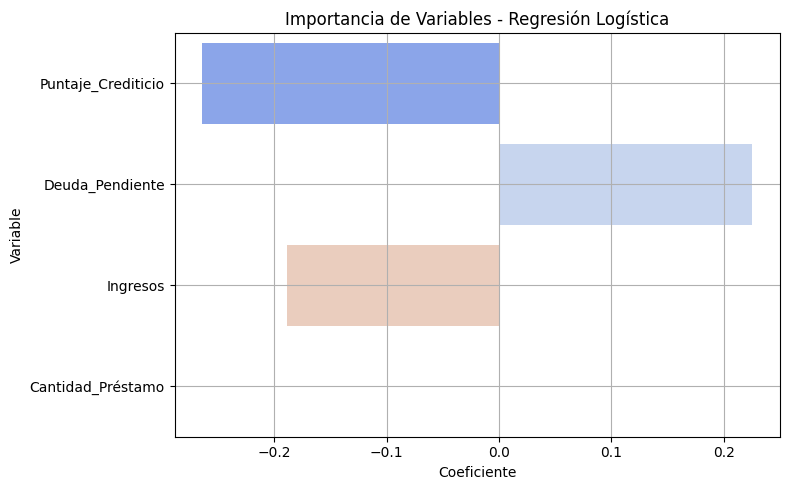

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-21-3799808510.py:35: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample, feature_names=final_columns)


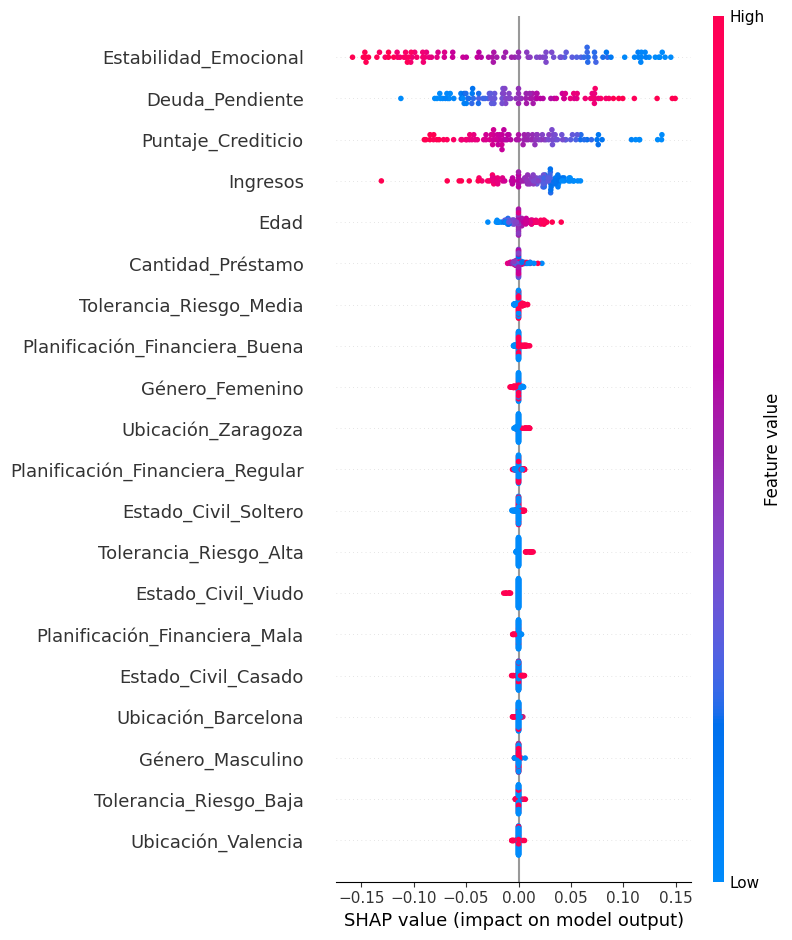

In [ ]:

coef = logreg.coef_[0]
features = X_train_fin.columns
coef_df = pd.DataFrame({'feature': features, 'coef': coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='coef', y='feature', data=coef_df, palette='coolwarm')
plt.title('Importancia de Variables - Regresión Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.grid(True)
plt.tight_layout()
plt.show()


# Esto se hace después de construir la ColumnTransformer
cat_columns = preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(categorical_cols)
final_columns = np.concatenate([numeric_cols, cat_columns])

# Submuestra para que el cálculo sea razonable
X_sample = X_train_processed[:100]
X_test_sample = X_test_processed[:100]

# Definir función de predicción compatible
predict_fn = lambda x: model.predict(x, verbose=0).flatten()

# Crear el explicador
explainer = shap.KernelExplainer(predict_fn, X_sample)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test_sample)

# Mostrar gráfico de resumen
shap.summary_plot(shap_values, X_test_sample, feature_names=final_columns)







####ANÁLISIS SENSIBILIDAD


In [ ]:
#  Variables financieras únicamente
variables_financieras = ["Ingresos", "Puntaje_Crediticio", "Deuda_Pendiente", "Cantidad_Préstamo"]
X_fin = synthetic_data[variables_financieras].copy()
X_fin["Ratio_Deuda_Ingresos"] = synthetic_data["Deuda_Pendiente"] / synthetic_data["Ingresos"]
y_fin = synthetic_data["Pago"]

#  Split y escalado
X_train_sens, X_test_sens, y_train_sens, y_test_sens = train_test_split(
    X_fin, y_fin, test_size=0.2, stratify=y_fin, random_state=42
)
scaler = StandardScaler()
X_train_sens_scaled = scaler.fit_transform(X_train_sens)
X_test_sens_scaled = scaler.transform(X_test_sens)

#  Pesos de clase
weights_sens = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_sens), y=y_train_sens)
class_weights_sens = {0: weights_sens[0], 1: weights_sens[1]}

#  Modelo
model_sens = Sequential([

    Dense(256, kernel_regularizer=l2(0.0005), input_shape=(X_train_sens_scaled.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),

    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.37),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.35),

    Dense(16),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.23),

    Dense(8),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

# Compilación
model_sens.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


#  Entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3)

history_sens = model_sens.fit(
    X_train_sens_scaled, y_train_sens,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_reduce],
    class_weight=class_weights_sens,
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4954 - loss: 0.7363 - val_accuracy: 0.4771 - val_loss: 0.6994 - learning_rate: 2.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5104 - loss: 0.7159 - val_accuracy: 0.5246 - val_loss: 0.6957 - learning_rate: 2.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5226 - loss: 0.7046 - val_accuracy: 0.5375 - val_loss: 0.6910 - learning_rate: 2.0000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5270 - loss: 0.6987 - val_accuracy: 0.5492 - val_loss: 0.6894 - learning_rate: 2.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5304 - loss: 0.6952 - val_accuracy: 0.5575 - val_loss: 0.6875 - learning_rate: 2.0000e-04
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5251 - loss: 0.6989 - val_accuracy: 0.5462 - val_loss: 0.6870 - learning_rate: 2.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.53

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Evaluación red neuronal SIN variables extra (umbral = 0.46):
              precision    recall  f1-score   support

           0       0.61      0.22      0.33      1388
           1       0.57      0.88      0.69      1612

    accuracy                           0.58      3000
   macro avg       0.59      0.55      0.51      3000
weighted avg       0.59      0.58      0.52      3000

AUC: 0.6128
Accuracy: 0.5753


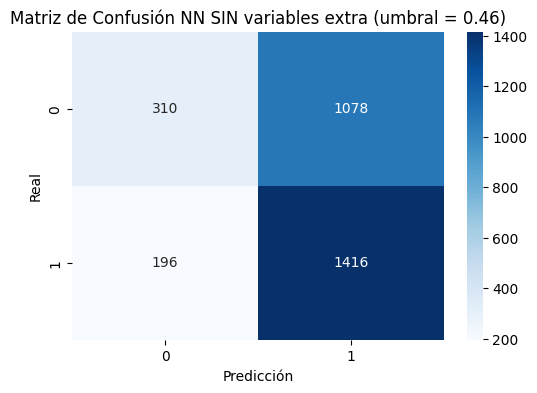

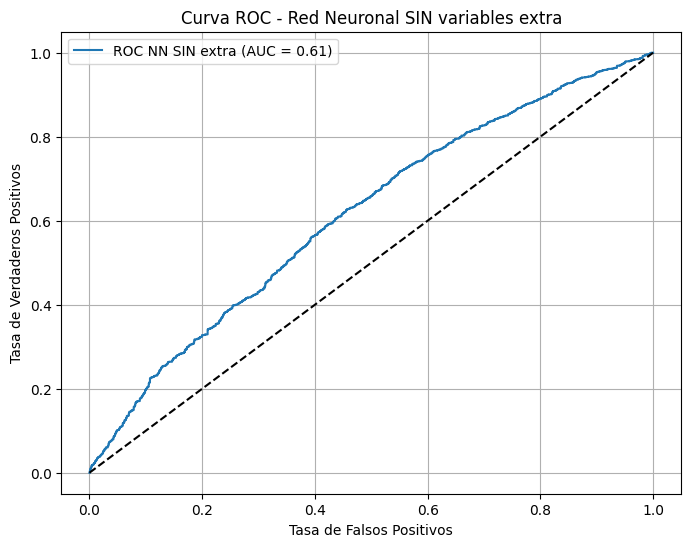

In [ ]:

#  Predicciones
y_pred_prob_sens = model_sens.predict(X_test_sens_scaled).ravel()
umbral = 0.46
y_pred_sens = (y_pred_prob_sens >= umbral).astype(int)

#  Métricas de clasificación
print(f"\nEvaluación red neuronal SIN variables extra (umbral = {umbral}):")
print(classification_report(y_test_sens, y_pred_sens))
print(f"AUC: {roc_auc_score(y_test_sens, y_pred_prob_sens):.4f}")
print(f"Accuracy: {accuracy_score(y_test_sens, y_pred_sens):.4f}")

#  Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_sens, y_pred_sens), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de Confusión NN SIN variables extra (umbral = {umbral})")
plt.show()

#  Curva ROC
fpr_sens, tpr_sens, _ = roc_curve(y_test_sens, y_pred_prob_sens)
auc_sens = roc_auc_score(y_test_sens, y_pred_prob_sens)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sens, tpr_sens, label=f'ROC NN SIN extra (AUC = {auc_sens:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Red Neuronal SIN variables extra")
plt.legend()
plt.grid(True)
plt.show()


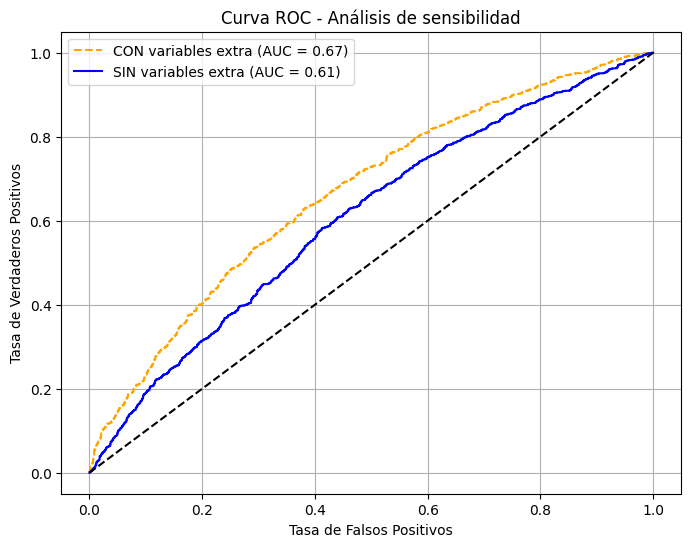

In [ ]:

# Curva ROC SIN variables extra (model_sens)
fpr_sens, tpr_sens, _ = roc_curve(y_test_sens, y_pred_prob_sens)
auc_sens = roc_auc_score(y_test_sens, y_pred_prob_sens)

# Curva ROC CON variables extra (model)
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_prob_nn)
auc_full = roc_auc_score(y_test, y_pred_prob_nn)

# Comparación visual
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, label=f'CON variables extra (AUC = {auc_full:.2f})', linestyle='--', color='orange')
plt.plot(fpr_sens, tpr_sens, label=f'SIN variables extra (AUC = {auc_sens:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Análisis de sensibilidad")
plt.legend()
plt.grid(True)
plt.show()
